# Sales Time Series Analysis and Forecasting
This notebook analyzes sales data with a focus on monthly and implements forecasting using LangChain and the Llama 3.2 model.


### 1. Import Required Libraries

In [87]:
!pip install seaborn

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from typing import List, Dict, Any
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

### 2. Load and Prepare Data
 Load sales data from the provided CSV file.

In [129]:
file_path = "data/sales_i.csv"

# Read data from CSV
data_columns = [
    "Order Date", "Product ID", "Product Name", "Sales_amount", "Quantity", "Discount", "Profit"
]

df = pd.read_csv(file_path, usecols=data_columns, parse_dates=["Order Date"], encoding='latin1')
print("Dataset Shape:", df.shape)
df[df['Product ID']=="P001"]

Dataset Shape: (18270, 7)


,Order Date,Product ID,Product Name,Sales_amount,Quantity,Discount,Profit
0,2016-01-01,P001,Product 1,202,8,0.29,28.68
1,2016-01-02,P001,Product 1,799,8,0.11,142.22
2,2016-01-03,P001,Product 1,921,8,0.23,141.83
3,2016-01-04,P001,Product 1,598,8,0.21,94.48
4,2016-01-05,P001,Product 1,970,8,0.21,153.26
...,...,...,...,...,...,...,...
1822,2020-12-27,P001,Product 1,601,13,0.06,112.99
1823,2020-12-28,P001,Product 1,564,13,0.25,84.60
1824,2020-12-29,P001,Product 1,475,13,0.05,90.25
1825,2020-12-30,P001,Product 1,375,13,0.30,52.50


### 3. Data Preparation and Feature Engineering
Add features like month start, month end, and day of the month, and perform monthly aggregation.


In [130]:
# Add month-related columns
df['MonthStart'] = df['Order Date'].dt.to_period('M').dt.start_time  # First day of the month
df['MonthEnd'] = df['MonthStart'] + pd.offsets.MonthEnd(0)  # Last day of the month

# Calculate revenue for aggregation
df['Revenue'] = df['Sales_amount'] * (1 - df['Discount'])

# Perform monthly aggregation
monthly_data = df.groupby(['MonthStart', 'Product ID']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'Sales_amount': 'mean',
    'Profit': 'mean',
    'Discount': 'mean'
}).reset_index()

print("Monthly Data Sample:")
monthly_data[monthly_data['Product ID'] == "P001"]

Monthly Data Sample:


,MonthStart,Product ID,Quantity,Revenue,Sales_amount,Profit,Discount
0,2016-01-01,P001,248,16508.55,628.387097,106.506452,0.154516
10,2016-02-01,P001,174,11222.71,456.862069,77.398621,0.158966
20,2016-03-01,P001,186,13209.85,505.645161,85.223871,0.150323
30,2016-04-01,P001,210,12817.26,499.300000,85.449000,0.138000
40,2016-05-01,P001,279,14607.70,550.387097,94.242903,0.153871
50,2016-06-01,P001,360,14367.00,555.466667,95.780333,0.153667
60,2016-07-01,P001,434,12936.38,496.000000,83.460323,0.165806
70,2016-08-01,P001,496,13866.71,511.451613,89.463226,0.128387
80,2016-09-01,P001,510,15980.44,625.466667,106.536333,0.148000
90,2016-10-01,P001,527,14013.02,527.548387,90.406774,0.150645


In [133]:
monthly_data['year'] = pd.DatetimeIndex(monthly_data['MonthStart']).year
monthly_data.head()

,MonthStart,Product ID,Quantity,Revenue,Sales_amount,Profit,Discount,year
0,2016-01-01,P001,248,16508.55,628.387097,106.506452,0.154516,2016
1,2016-01-01,P002,279,13937.50,518.000000,89.919677,0.145484,2016
2,2016-01-01,P003,310,13471.85,506.806452,86.915484,0.151290,2016
3,2016-01-01,P004,341,12551.10,494.258065,80.974839,0.175806,2016
4,2016-01-01,P005,372,17508.66,664.419355,112.959355,0.142258,2016


In [153]:
# Add trend
from random import randrange

for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    monthly_data['Quantity'] = np.where(monthly_data['year'] == year,
                                           monthly_data['Quantity'] * randrange(2, 6),
                                           monthly_data['Quantity'])

In [154]:
monthly_data[monthly_data['Product ID']=="P001"]

,MonthStart,Product ID,Quantity,Revenue,Sales_amount,Profit,Discount,year
0,2016-01-01,P001,744,16508.55,628.387097,106.506452,0.154516,2016
10,2016-02-01,P001,522,11222.71,456.862069,77.398621,0.158966,2016
20,2016-03-01,P001,558,13209.85,505.645161,85.223871,0.150323,2016
30,2016-04-01,P001,630,12817.26,499.300000,85.449000,0.138000,2016
40,2016-05-01,P001,837,14607.70,550.387097,94.242903,0.153871,2016
50,2016-06-01,P001,1080,14367.00,555.466667,95.780333,0.153667,2016
60,2016-07-01,P001,1302,12936.38,496.000000,83.460323,0.165806,2016
70,2016-08-01,P001,1488,13866.71,511.451613,89.463226,0.128387,2016
80,2016-09-01,P001,1530,15980.44,625.466667,106.536333,0.148000,2016
90,2016-10-01,P001,1581,14013.02,527.548387,90.406774,0.150645,2016


### 4. Visualize Monthly Patterns
Visualize the monthly sales trends.

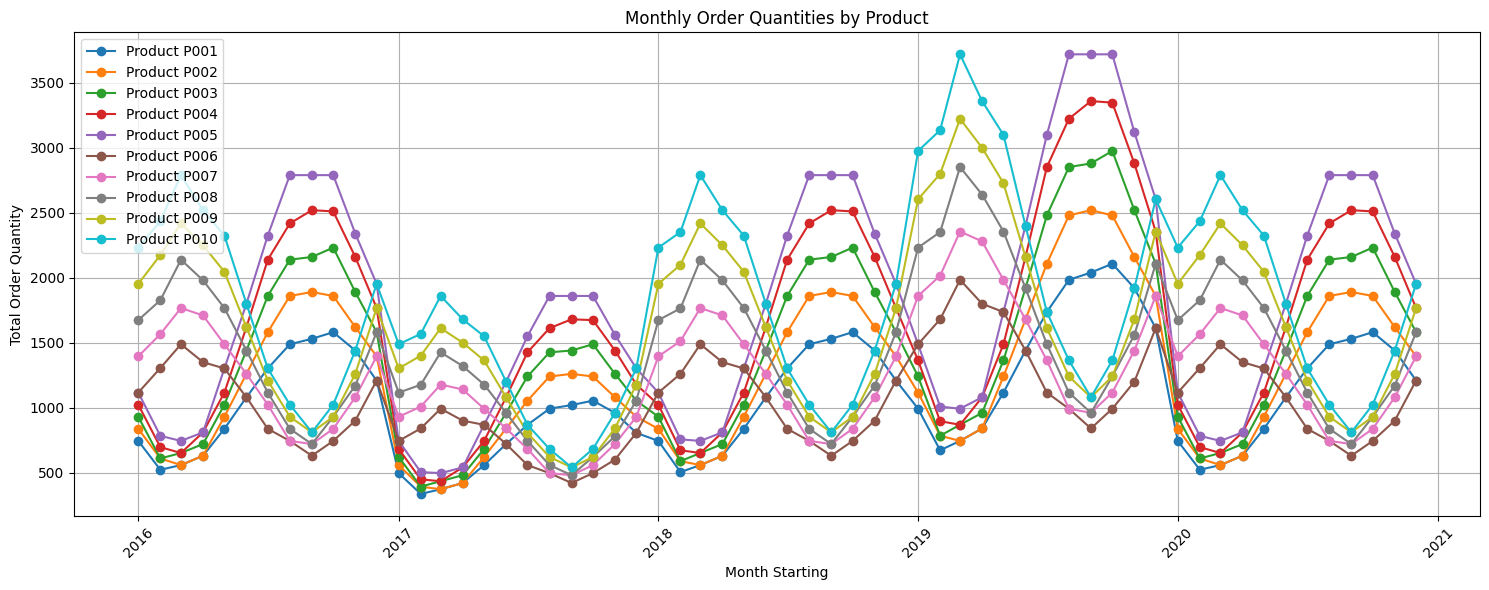

In [156]:
# Plot monthly order quantities
plt.figure(figsize=(15, 6))
for product in df['Product ID'].unique():
    product_data = monthly_data[monthly_data['Product ID'] == product]
    plt.plot(product_data['MonthStart'], product_data['Quantity'], 
             label=f'Product {product}', marker='o')
    
plt.title('Monthly Order Quantities by Product')
plt.xlabel('Month Starting')
plt.ylabel('Total Order Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### 5. Rolling Statistics
Calculate and visualize 3-month rolling statistics.


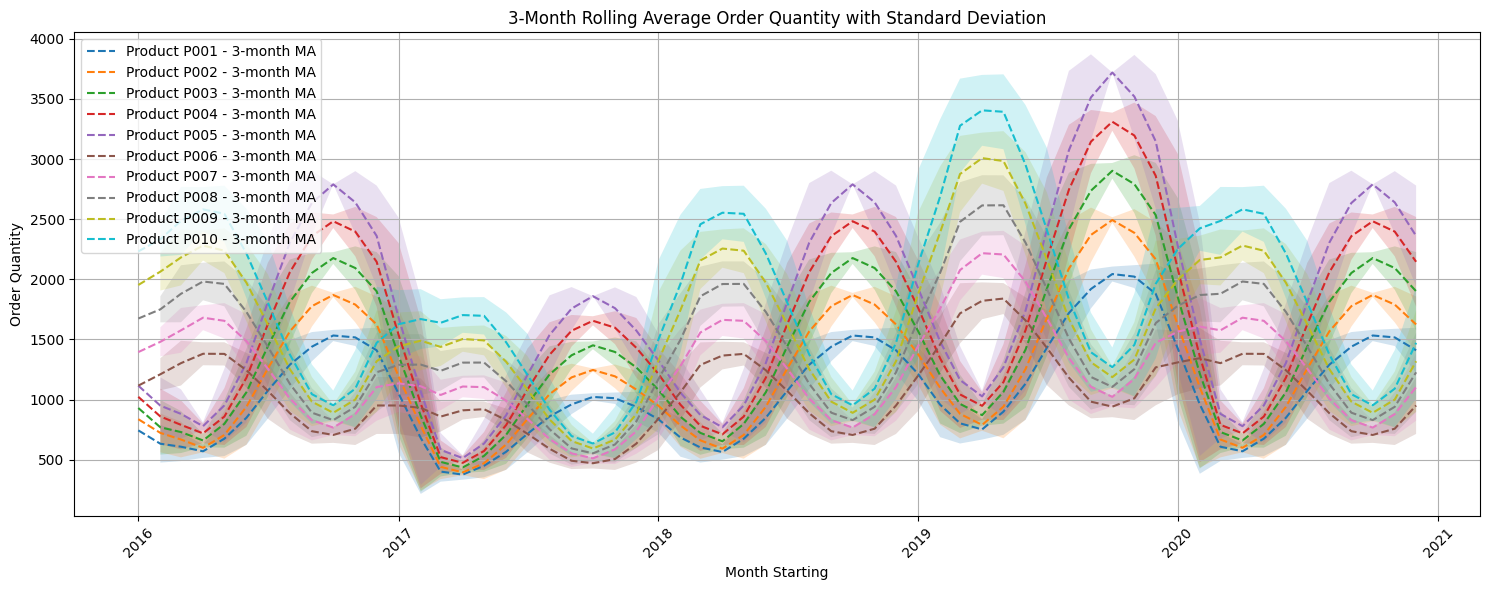

In [157]:
# Calculate and visualize 3-month rolling statistics with respect to every month.

monthly_data['rolling_qty_mean'] = monthly_data.groupby('Product ID')['Quantity'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean())
monthly_data['rolling_qty_std'] = monthly_data.groupby('Product ID')['Quantity'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std())

# Visualize rolling statistics
plt.figure(figsize=(15, 6))
for product in df['Product ID'].unique():
    product_data = monthly_data[monthly_data['Product ID'] == product]
    plt.plot(product_data['MonthStart'], product_data['rolling_qty_mean'], 
             label=f'Product {product} - 3-month MA', linestyle='--')
    plt.fill_between(product_data['MonthStart'],
                     product_data['rolling_qty_mean'] - product_data['rolling_qty_std'],
                     product_data['rolling_qty_mean'] + product_data['rolling_qty_std'],
                     alpha=0.2)

plt.title('3-Month Rolling Average Order Quantity with Standard Deviation')
plt.xlabel('Month Starting')
plt.ylabel('Order Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Forecasting with LangChain
Prepare data for the Llama 3.2 model, generate a forecast, and visualize results.


In [174]:
    # 3. **Monthly fluctuations**: Identify how each month behaves, and forecast based on the previous month's trends.
    # 4. **Growth or Decline**: Based on historical sales, determine if the product is growing, stable, or declining, and adjust the forecast accordingly.

# Setup ChatOllama model
llm = ChatOllama(
    model="llama3.2",
    max_tokens=2000,
    verbose=True
)

monthly_prompt = PromptTemplate(
    input_variables=["historical_data", "product_id", "forecast_horizon"],
    template="""
    Given the following monthly sales data for ProductID {product_id}:

    {historical_data}

    Your task is to forecast the order quantities for the next {forecast_horizon} months from the date provide data ends. Focus on the following:

    1. **Trend analysis**: Identify any upward or downward trends in the recent months. How does the quantity change over time, and what are the possible reasons for it?
    2. **Seasonality**: Recognize any repeating seasonal patterns (e.g., higher sales during specific months like holidays, end-of-year promotions, etc.).
     3. **Monthly fluctuations**: Identify how each month behaves, and forecast based on the previous month's trends.
     4. **Growth or Decline**: Based on historical sales, determine if the product is growing, stable, or declining, and adjust the forecast accordingly.

    Please provide the forecast for the next {forecast_horizon} months, with the following details for each month:
    - **month_start**: The starting date of the month in "YYYY-MM-DD" format
    - **forecast_quantity**: The forecasted order quantity for the month
    - **confidence**: A numerical confidence value (from 0 to 1) indicating the reliability of the forecast

    Provide the forecast as a **JSON array**. Only return the JSON array, without any additional text or code formatted like below
    {{"month_start": "YYYY-MM-DD", "forecast_quantity": number, "confidence": number}}

    Please make sure the output is in valid JSON format.
    Do not provide any additional text. Focus on delivering an accurate forecast.
    """
)

In [177]:
# Select product and prepare historical data
product_id = "P002"
lookback_months = 60

historical_data = monthly_data[
    (monthly_data['Product ID'] == product_id) &
    (monthly_data['MonthStart'] > monthly_data['MonthStart'].max() - pd.offsets.MonthEnd(lookback_months))
].copy()

# Prepare the historical data for the model
historical_data_json = historical_data[['MonthStart', 'Quantity']].copy()
historical_data_json['MonthStart'] = pd.to_datetime(historical_data_json['MonthStart'])

# Filter the data to include only rows with 'MonthStart' less than '2020-10-01'
#historical_data_json = historical_data_json[historical_data_json['MonthStart'] < pd.Timestamp('2019-12-01')]

# Convert the 'MonthStart' column back to the desired string format
historical_data_json['MonthStart'] = historical_data_json['MonthStart'].dt.strftime('%Y-%m-%d')


Model response: [
  {"month_start": "2020-12-01", "forecast_quantity": 1860, "confidence": 1},
  {"month_start": "2021-01-01", "forecast_quantity": 837, "confidence": 0.75},
  {"month_start": "2021-02-01", "forecast_quantity": 609, "confidence": 0.55}
]


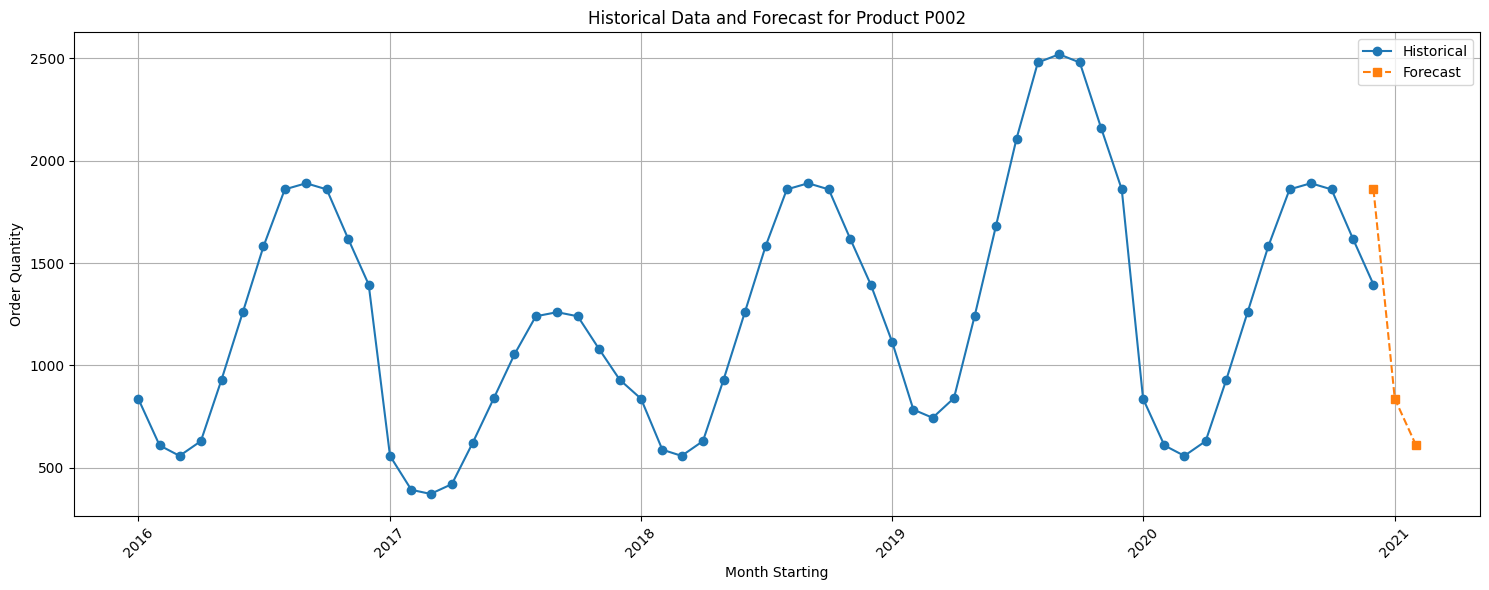

In [178]:
import json
chain = LLMChain(llm=llm, prompt=monthly_prompt)

try:
    response = chain.run({
        "historical_data": historical_data_json.to_json(orient='records'),
        "product_id": product_id,
        "forecast_horizon": 3  # Forecast for the next 3 months
    })
    
    # Print the response to inspect its structure
    print(f"Model response: {response}")
    
    # Check if the response is empty or malformed
    if not response.strip():
        raise ValueError("Received an empty response from the model.")
    
    # Safely parse the forecast response as JSON using json.loads
    try:
        forecast = json.loads(response)  # Use json.loads to safely parse the JSON string
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parsing JSON: {e}")

    # Check if 'month_start' exists in the forecast
    if 'month_start' not in forecast[0]:
        raise ValueError('Missing "month_start" field in the forecast response.')

    # Convert forecast to DataFrame for visualization
    forecast_df = pd.DataFrame(forecast)
    forecast_df['month_start'] = pd.to_datetime(forecast_df['month_start'])

    # Plot historical data and forecast
    plt.figure(figsize=(15, 6))
    plt.plot(historical_data['MonthStart'], historical_data['Quantity'], 
             label='Historical', marker='o')
    plt.plot(forecast_df['month_start'], forecast_df['forecast_quantity'], 
             label='Forecast', marker='s', linestyle='--')
    plt.title(f'Historical Data and Forecast for Product {product_id}')
    plt.xlabel('Month Starting')
    plt.ylabel('Order Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating forecast: {e}")
